# Workshop 6: Random Projections with Annoy

Random projections is a form of *dimensionality reduction*

Main benefit of random projections over more "traditional" dimensionality reduction approaches (e.g. PCA):

**Computational efficiency.**

Let's say we have some data we want to group using spectral clustering. We know how to do this:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skds
from sklearn.metrics.pairwise import rbf_kernel

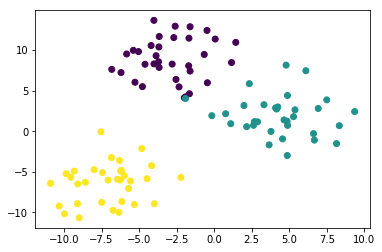

In [2]:
X, y = skds.make_blobs(cluster_std = 2.5, shuffle = False, random_state = 42)
plt.scatter(X[:, 0], X[:, 1], c = y)

In [3]:
A = rbf_kernel(X, X, gamma = 0.05)
d = A.sum(axis = 1)
L = np.diag(d ** -0.5).dot(A).dot(np.diag(d ** -0.5))

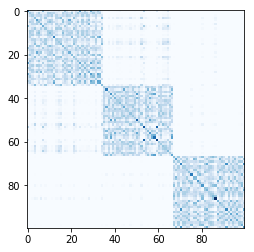

In [4]:
plt.imshow(L, cmap = "Blues")

The whole point of spectral clustering is to find a **low-dimensional embedding of the data that is easily separable.** That's what the eigenvectors of the graph Laplacian are.

In [5]:
import scipy.linalg as sla
evals, evecs = sla.eigh(L)

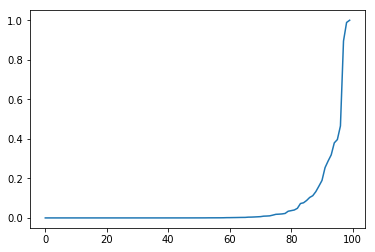

In [6]:
plt.plot(evals)

In [7]:
print(evals[-5:])

[ 0.39636895  0.46524144  0.89505242  0.98872511  1.        ]


Remember: ignore the "trivial" $\lambda = 1$ eigenvalue and corresponding eigenvector, and take some $k$ of the rest.

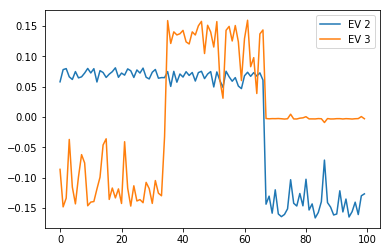

In [8]:
plt.plot(evecs[:, -2], label = "EV 2")
plt.plot(evecs[:, -3], label = "EV 3")
plt.legend(loc = 0)

We'll take the next two, so our data are still 2D.

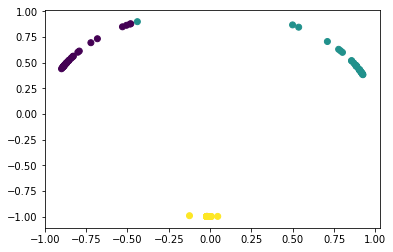

In [9]:
U = evecs[:, -3:-1]
V = U / sla.norm(U, axis = 1, keepdims = True)
plt.scatter(V[:, 0], V[:, 1], c = y)

Pretty easy to cluster, right?

### So why do we need a different dimensionality reduction method?

**The PCA step is *expensive*.**

In [10]:
%timeit sla.eigh(L)

13.6 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


$\mathcal{O}(10^{-3})$ seconds is pretty good, but how does it scale?

Let's take a look at a slightly larger dataset.

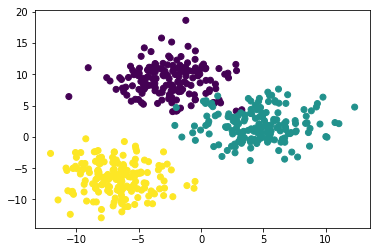

In [11]:
X, y = skds.make_blobs(n_samples = 500, cluster_std = 2.5, shuffle = False, random_state = 42)
plt.scatter(X[:, 0], X[:, 1], c = y)

Same data as before, just 5x of it.

In [12]:
A = rbf_kernel(X, X, gamma = 0.05)
d = A.sum(axis = 1)
L = np.diag(d ** -0.5).dot(A).dot(np.diag(d ** -0.5))

In [13]:
%timeit sla.eigh(L)

69.5 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Still within the $\mathcal{O}(10^{-3})$ order of magnitude, and pretty much exactly 5x increase in runtime for 5x increase in data size.

Let's 5x it again.

In [14]:
X, y = skds.make_blobs(n_samples = 2500, cluster_std = 2.5, shuffle = False, random_state = 42)
A = rbf_kernel(X, X, gamma = 0.05)
d = A.sum(axis = 1)
L = np.diag(d ** -0.5).dot(A).dot(np.diag(d ** -0.5))

In [15]:
%timeit sla.eigh(L)

3.61 s ± 432 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, decidedly in exponential territory now: 5x increase in data size, 2 *orders of magnitude* increase in runtime.

### Rather than use a deterministic linear solver, let's try generating random numbers.

In [16]:
import sklearn.random_projection as rp

In [17]:
transformer = rp.GaussianRandomProjection(n_components = 2)
U = transformer.fit_transform(X)

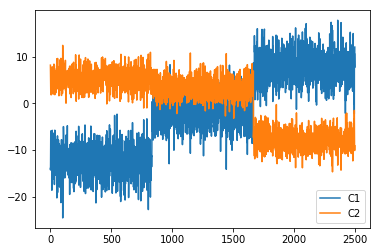

In [18]:
plt.plot(U[:, 0], label = "C1")
plt.plot(U[:, 1], label = "C2")
plt.legend(loc = 0)

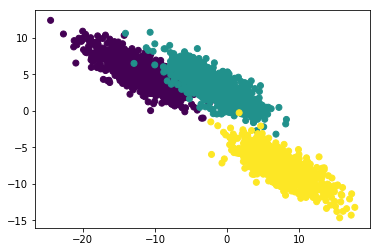

In [19]:
plt.scatter(U[:, 0], U[:, 1], c = y)

What about that critical step?

In [20]:
t = rp.GaussianRandomProjection(n_components = 2)
%timeit t.fit_transform(X)

217 µs ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That's faster than the fastest deterministic solver!

### What happened?

We generated *completely random vectors* (in this case, sampled from 2-dimensional Gaussians) and projected the data against those vectors.

### Why does this even work?

**Topic for next Tuesday's lecture!**

### What does this have to do with clustering?

That's where the "approximate nearest neighbors" comes in.

## Nearest Neighbors

One of the simplest methods of classification, regression, and even unsupervised clustering in some cases, is *Nearest Neighbors*.

Nearest neighbors is known as an *instance-based model*, because there's not really any actual learning done: when a new data point comes in, it takes the label of the majority of its nearest neighbors. 

![nn](http://scikit-learn.org/stable/_images/sphx_glr_plot_classification_0011.png)

In the above figure, we've set the neighborhood to consist of $k = 15$ nearest data points. This means, for any new data point, its label is the majority label of the nearest 15 points. That's it!

There are variations, such as *weighted* nearest neighbors.

![nn2](http://scikit-learn.org/stable/_images/sphx_glr_plot_classification_0021.png)

Here's the same data with the same $k = 15$ neighborhood, but the votes of the 15 nearest neighbors are weighted by how far away from the query data point they are. The closer the neighbors are to the query data point, the more their votes count.

An obvious bottleneck is computing the neighborhood, i.e. determining the actual nearest neighbors.

The first and easiest way of finding the neighborhood is to compute pairwise distances between the query point and the *entire* dataset.

Another way is to build a K-D Tree of the data, which is slightly more efficient.

![kdtree](https://upload.wikimedia.org/wikipedia/commons/9/9c/KDTree-animation.gif)

But for large data, this is still expensive.

**So let's combine our knowledge of embeddings with this concept of random projections.**

### Approximate Nearest Neighbors, Oh Boy ("Annoy")

![annoy](https://camo.githubusercontent.com/d6bf20e534ab76b67c731b566859a24149a4bf80/68747470733a2f2f7261772e6769746875622e636f6d2f73706f746966792f616e6e6f792f6d61737465722f616e6e2e706e67)

[**Annoy**](https://github.com/spotify/annoy) is used by Spotify for finding music recommendations for users (the "nearest neighbors").

Since Spotify has tons and tons and *tons* of music with more presumably being added all the time, even K-D Trees would be too expensive at this scale.

Annoy uses random projections to split up the search space, and find *approximate* nearest neighbors without having to search virtually any of the data by hand.

Each random vector projects/"embeds" the data into a space where it can be used to build approximate K-D Trees. Specifically, at every intermediate node in the tree, a random hyperplane is chosen, which divides the space into two subspaces. This hyperplane is chosen by sampling two points from the subset and taking the hyperplane equidistant from them.

This is done $k$ times so that we get a forest of trees. $k$ has to be tuned to your need, by looking at what tradeoff you have between precision and performance.

The other parameter to Annoy, $n$, controls the number of trees, or samples used to generate hyperplanes.

Let's see Annoy in action.

In [21]:
# Let's set up a dataset.
iris = skds.load_iris()

# We only take the first two features.
X = iris.data[:, :2]
y = iris.target

In [22]:
from annoy import AnnoyIndex

f = X.shape[1]
t = AnnoyIndex(f)  # Length of item vector that will be indexed
for index, item in enumerate(X):
    t.add_item(index, item)

t.build(-1) # default number of trees

True

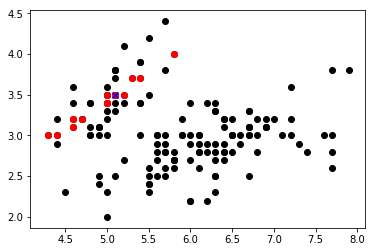

In [23]:
query_id = 0

query_data = t.get_item_vector(query_id)
neighbor_ids = t.get_nns_by_item(0, 15) # will find the 10 nearest neighbors
neighbors = np.array([t.get_item_vector(i) for i in neighbor_ids])

plt.scatter(X[:, 0], X[:, 1], c = 'k')
plt.scatter(neighbors[:, 0], neighbors[:, 1], c = 'r')
plt.scatter(query_data[0], query_data[1], c = 'b', marker = 'x')

### How about really large datasets?

In [24]:
X, y = skds.make_blobs(n_samples = 2500, n_features = 10, random_state = 6542)  # 10-dimensional gaussians

In [25]:
from annoy import AnnoyIndex

f = X.shape[1]
t = AnnoyIndex(f)  # Length of item vector that will be indexed
for index, item in enumerate(X):
    t.add_item(index, item)

%timeit t.build(-1) # default number of trees

29.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


440 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


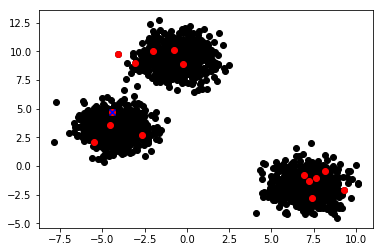

In [26]:
query_id = 0

query_data = t.get_item_vector(query_id)
%timeit neighbor_ids = t.get_nns_by_item(0, 15) # will find the 15 nearest neighbors
neighbors = np.array([t.get_item_vector(i) for i in neighbor_ids])

plt.scatter(X[:, 0], X[:, 1], c = 'k')
plt.scatter(neighbors[:, 0], neighbors[:, 1], c = 'r')
plt.scatter(query_data[0], query_data[1], c = 'b', marker = 'x')

(keep in mind: full data are 10-dimensional, so even though neighbors don't appear in the same clusters doesn't mean they're not neighbors in the 10-dimensional space)

Let's compare this to scikit-learn's nearest neighbor algorithm.

In [27]:
import sklearn.neighbors

In [28]:
nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 15)
%timeit nn.fit(X, y)

1.51 ms ± 39.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
